<a href="https://colab.research.google.com/github/qilin512/OUC-ComputerVision/blob/main/project/02-HDRI/High_Dynamic_Range_Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High Dynamic Range Imaging

In this project, we will learn how to create a High Dynamic Range (HDR) image using multiple images taken with different exposure settings. Most of the contents are borrowed from [this tutorial](https://learnopencv.com/high-dynamic-range-hdr-imaging-using-opencv-cpp-python/). And there is [another good tutorial](https://www.researchgate.net/publication/327545585_Deep_dive_into_high_dynamic_range_imaging_a_Matlab_tutorial) with Matlab code you may like to read. Matlab also provides a web based HDR image [renderer](https://ww2.mathworks.cn/company/newsletters/articles/rendering-high-dynamic-range-images-on-the-web.html) that you may want to try.

### What is High Dynamic Range (HDR) imaging?
Most digital cameras and displays capture or display color images as 24-bits matrices. There are 8-bits per color channel and the pixel values are therefore in the range 0–255 for each channel. In other words, a regular camera or a display has a limited dynamic range.

However, the world around us has a very large dynamic range. It can get pitch black inside a garage when the lights are turned off and it can get really bright if you are looking directly at the Sun. Even without considering those extremes, in everyday situations, 8-bits are barely enough to capture the scene. So, the camera tries to estimate the lighting and automatically sets the exposure so that the most interesting aspect of the image has good dynamic range, and the parts that are too dark and too bright are clipped off to 0 and 255 respectively.

In the Figure below, the image on the left is a normally exposed image. Notice the sky in the background is completely washed out because the camera decided to use a setting where the subject (a boy) is properly photographed, but the bright sky is washed out. The image on the right is an HDR image produced by the iPhone.

<img src="https://github.com/qilin512/OUC-ComputerVision/blob/main/project/02-HDRI/high-dynamic-range-hdr.jpg?raw=1" />

How does an iPhone capture an HDR image? It actually takes 3 images at three different exposures. The images are taken in quick succession so there is almost no movement between the three shots. The three images are then combined to produce the HDR image. We will see the details in the next section.

> The process of combining different images of the same scene acquired under different exposure settings is called High Dynamic Range (HDR) imaging.

To summarize, 传统图像具有256级像素亮度范围，而High dynamic range (HDR，高动态范围)have much larger dynamic range than traditional images' 256 brightness levels. In addition, they correspond linearly 线性对应 to physical irradiance values of the scene 场景中物理辐照度. Hence, they have many applications in graphics and vision. In this project, you are expected to finish the following tasks to assemble an HDR image.

## Step 1: Capture multiple images with different exposures

Taking images. Taking a series of photographs for a scene under different exposures 曝光. As discussed in the class, changing shutter speed 快门速度 is probably the best way to change exposure for this application. For that, you need a digital camera that allows you to set exposures. (Note that not every camera allows a user to manually set exposures.) You can use your own camera on your cellphone. 我的华为手机摄像程序里有“专业”模式，可以设置快门速度，如下图所示，标黄的那里就是修改快门的地方。

<img src="https://github.com/qilin512/OUC-ComputerVision/blob/main/project/02-HDRI/my_phone.jpg?raw=1" style="zoom:30%" />

One thing to note is that you should avoid moving your camera during this process so that all pictures are well registered.要保持相机静止，否则发生图像像素的错位。 Some digital cameras have their own programs which allow users to remotely control the shutters via their USB cables.单反相机有线控快门或者usb连到电脑上通过软件控制拍摄。 Using such programs prevent you from shaking the camera while pressing the shutter. You are welcome to write down your findings for that matter in your report.

If you don't want to capture your own images, you can use those images come with this notebook. Unzip the "exposure.zip" or "Memorial_SourceImages.zip" or "hdr.zip" and you will see a folder of a series of images. The exposure time comes with the image in a text file (the "exposure" and "Memorial_SourceImages" datasets) or is just indicated in the file name ("hdr" dataset). [Debevec's](http://www.pauldebevec.com/Research/HDR/) [images](http://www.debevec.org/Research/HDR/SourceImages/Memorial_SourceImages.zip) are also provided.

In [1]:
# unzip the dataset provided or your own uploaded data
# !cd data/data54145/ && unzip -o exposures.zip -d exposures
!unzip -o exposures.zip -d exposures
!unzip -o Memorial_SourceImages.zip -d Memorial_SourceImages
!unzip -o hdr.zip -d hdr

Archive:  exposures.zip
  inflating: exposures/img03.jpg     
  inflating: exposures/img04.jpg     
  inflating: exposures/img05.jpg     
  inflating: exposures/img06.jpg     
  inflating: exposures/img07.jpg     
  inflating: exposures/img08.jpg     
  inflating: exposures/img09.jpg     
  inflating: exposures/img10.jpg     
  inflating: exposures/img11.jpg     
  inflating: exposures/img12.jpg     
  inflating: exposures/img13.jpg     
  inflating: exposures/shutter.txt   
  inflating: exposures/img01.jpg     
  inflating: exposures/img02.jpg     
Archive:  Memorial_SourceImages.zip
  inflating: Memorial_SourceImages/memorial0063.png  
  inflating: Memorial_SourceImages/memorial0064.png  
  inflating: Memorial_SourceImages/memorial0065.png  
  inflating: Memorial_SourceImages/memorial0066.png  
  inflating: Memorial_SourceImages/memorial0067.png  
  inflating: Memorial_SourceImages/memorial0068.png  
  inflating: Memorial_SourceImages/memorial0069.png  
  inflating: Memorial_SourceIm

**Please write your own code to load the images and exposure times**

In [2]:
# read images and exposure times
import cv2
import numpy as np

### TODO: write your code to load the images and corresponding exposure times. Note that the exposure times are in the text file "shutter.txt".
images = [cv2.imread(x) for x in ['./hdr/img_15.jpg', './hdr/img_2.5.jpg', './hdr/img_0.25.jpg', './hdr/img_0.033.jpg']]
times = np.array([15.0, 2.5, 0.25, 0.033]).astype(np.float32)

## Step 2: Align Images

Misalignment of images used in composing the HDR image can result in severe artifacts. In the Figure below, the image on the left is an HDR image composed using unaligned images and the image on the right is one using aligned images. By zooming into a part of the image, shown using red circles, we see severe ghosting artifacts in the left image.

<img src="https://github.com/qilin512/OUC-ComputerVision/blob/main/project/02-HDRI/aligned-unaligned-hdr-comparison.jpg?raw=1" />

Naturally, while taking the pictures for creating an HDR image, professional photographer mount the camera on a tripod. They also use a feature called mirror lockup to reduce additional vibrations. Even then, the images may not be perfectly aligned because there is no way to guarantee a vibration-free environment. The problem of alignment gets a lot worse when images are taken using a handheld camera or a phone.

Fortunately, OpenCV provides an easy way to align these images using AlignMTB. This algorithm converts all the images to median threshold bitmaps (MTB). An MTB for an image is calculated by assigning the value 1 to pixels brighter than median luminance and 0 otherwise. An MTB is invariant to the exposure time. Therefore, the MTBs can be aligned without requiring us to specify the exposure time.

MTB based alignment is performed using the following lines of code.

In [3]:
# Align input images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

## Step 3: Recover the Camera Response Function

Write a program to assemble 合成 an HDR image. Write a program to take these captured images as inputs and output an HDR image as well as the response curve of the camera 相机的响应曲线. You will use the `Debevec's method`. Please refer to Debevec's SIGGRAPH 1997 paper below. The most difficult part probably is to solve the over-determined linear system.

Paul E. Debevec, Jitendra Malik, [Recovering High Dynamic Range Radiance Maps from Photographs](http://pages.cs.wisc.edu/~lizhang/courses/cs766-2008f/projects/hdr/debevec-siggraph97.pdf), SIGGRAPH 1997.

这篇文章的方法首先要恢复相机的响应函数Recover the Camera Response Function
The response of a typical camera is not linear非线性 to scene brightness. What does that mean? Suppose, two objects are photographed by a camera and one of them is twice as bright as the other in the real world. When you measure the pixel intensities of the two objects in the photograph, the pixel values of the brighter object will not be twice that of the darker object! Without estimating the Camera Response Function (CRF), we will not be able to merge the images into one HDR image.

What does it mean to merge multiple exposure images into an HDR image?通过多张不同曝光的图像如何合成一个HDR图像？

Consider just ONE pixel at some location (x,y) of the images. If the CRF was linear假设相机响应函数是线性的, the pixel value would be directly proportional to the exposure time unless the pixel is too dark ( i.e. nearly 0 ) or too bright ( i.e. nearly 255) in a particular image. We can filter out these bad pixels ( too dark or too bright ), and estimate the brightness at a pixel by dividing the pixel value by the exposure time and then averaging this brightness value across all images where the pixel is not bad ( too dark or too bright ). We can do this for all pixels and obtain a single image where all pixels are obtained by averaging “good” pixels.把“好的”像素挑出来，亮度除以曝光时间，然后多张图像取平均即可。

But the CRF is not linear and we need to make the image intensities linear before we can merge/average them by first estimating the CRF.

The good news is that the CRF can be estimated from the images if we know the exposure times for each image. Like many problems in computer vision, the problem of finding the CRF is set up as an optimization problem where the goal is to minimize an objective function consisting of a data term and a smoothness term. These problems usually reduce to a linear least squares problem which are solved using Singular Value Decomposition (SVD) that is part of all linear algebra packages. The details of the CRF recovery algorithm are in the paper titled Recovering High Dynamic Range Radiance Maps from Photographs.

Finding the CRF is done using just two lines of code in OpenCV using CalibrateDebevec or CalibrateRobertson. In this project we will use CalibrateDebevec:

In [4]:
# Obtain Camera Response Function (CRF) using OpenCV functions. Note that the image array should be in descending order of exposure times.
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

The figure below shows the CRF recovered using the images for the red, green and blue channels. Note that the calibrated intensity is after an exponential operation.

<img src="https://github.com/qilin512/OUC-ComputerVision/blob/main/project/02-HDRI/camera-response-function.jpg?raw=1" />



Please write your own code for recovering CRF using Debevec's algorithm. Note that the image has RGB three channels, and you need to precess each channel separately.

The most important part is to resemble the matrix for the linear system.

<img src="https://github.com/qilin512/OUC-ComputerVision/blob/main/project/02-HDRI/Ax=b.jpg?raw=1" style="zoom:100%" />


In [5]:
### TODO: implementation of Debevec's CRF recovering algorithm. You need to return the crf (descrete array) for each channel.
import random

#make three channels
def split(images):
    i_b, i_g, i_r = [], [], []
    for i in images:
        b, g, r = cv2.split(i)
        i_b.append(b)
        i_g.append(g)
        i_r.append(r)
    return i_b, i_g, i_r

#weight
def weight(z,zmin=0,zmax=255):
    zmid = (zmin + zmax) / 2
    return z - zmin if z <= zmid else zmax - z

# Firstly, randomly select N points
def hdr_debvec(images,times,l,sample_num):
    global w
    B = np.log2(times)
    w  = [weight(z) for z in range(256)]
    samples = [(random.randint(0, images[0].shape[0] - 1), random.randint(0, images[0].shape[1] - 1)) for i in
               range(sample_num)]
    Z = []
    for img in images:
        Z += [[img[r[0]][r[1]] for r in samples]]
    Z = np.array(Z).T
    return gsolve(Z, B, l, w)
    
def gsolve(Z, B, l, w):
    n = 256
    # Secondly, generate the matrix A and b
    A = np.zeros(shape=(np.size(Z, 0) * np.size(Z, 1) + n + 1, n + np.size(Z, 0)), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data−fitting equations
    k = 0
    for i in range(np.size(Z, 0)):
        for j in range(np.size(Z, 1)):
            z = int(Z[i][j])
            wij = w[z]
            A[k][z] = wij
            A[k][n + i] = -wij
            b[k] = wij * B[j]
            k += 1
    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1
    # 平滑处理
    for i in range(n - 1):
        A[k][i] = l * w[i + 1]
        A[k][i + 1] = -2 * l * w[i + 1]
        A[k][i + 2] = l * w[i + 1]
        k += 1
    # Thirdly, solve the linear system using SVD
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    g = x[:256]
    lE = x[256:]

    return g, lE
    
# Finally, return the crf, which should be a numpy array of shape (3, 256) as we have 3 channels
def getCRF(images,times,l=10,sam_num=70):
    _b, _g, _r = split(images)
    image_gb, lEb = hdr_debvec(_b, times, l, sam_num)
    image_gg, lEg = hdr_debvec(_g, times, l, sam_num)
    image_gr, lEr = hdr_debvec(_r, times, l, sam_num)
    # 返回三个通道对应g、lE
    return [image_gb, image_gg, image_gr]


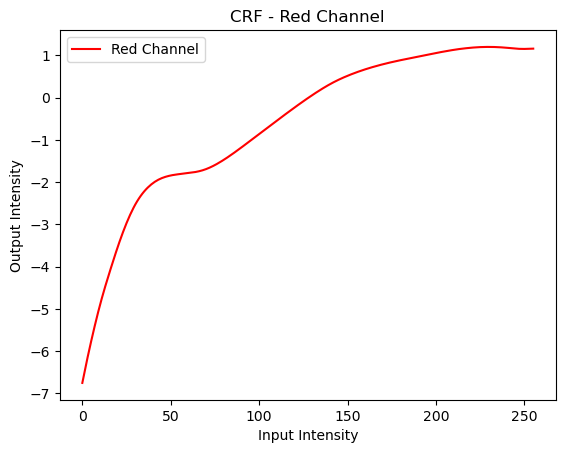

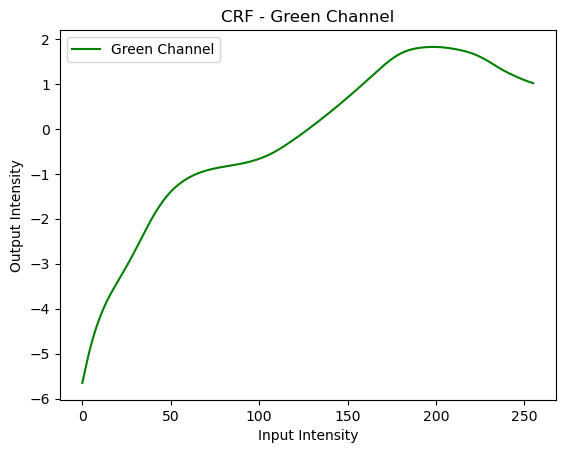

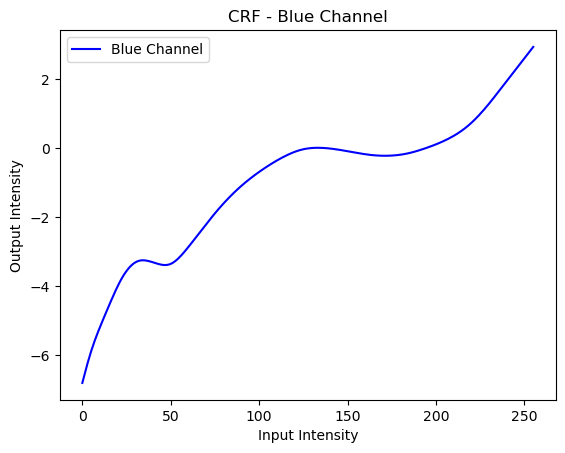

In [6]:
### TODO: plot the CRF (3 plots for 3 channels) you have recovered.
import matplotlib.pyplot as plt

crf = getCRF(images,times,l=50)

red_crf = crf[0]
green_crf = crf[1]
blue_crf = crf[2]

#plt.figure(figsize=(12, 4))

# 创建x轴坐标
x = np.linspace(0, 255, len(red_crf))

# 绘制红色通道的CRF曲线
plt.plot(x,red_crf, color='red', label='Red Channel')
plt.xlabel('Input Intensity')
plt.ylabel('Output Intensity')
plt.title('CRF - Red Channel')
plt.legend()
plt.show()

# 绘制绿色通道的CRF曲线
plt.plot(x, green_crf, color='green', label='Green Channel')
plt.xlabel('Input Intensity')
plt.ylabel('Output Intensity')
plt.title('CRF - Green Channel')
plt.legend()
plt.show()

# 绘制蓝色通道的CRF曲线
plt.plot(x, blue_crf, color='blue', label='Blue Channel')
plt.xlabel('Input Intensity')
plt.ylabel('Output Intensity')
plt.title('CRF - Blue Channel')
plt.legend()
plt.show()


### Step 3: Merge Images

Once the CRF has been estimated, we can merge the exposure images into one HDR image using MergeDebevec with OpenCV.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


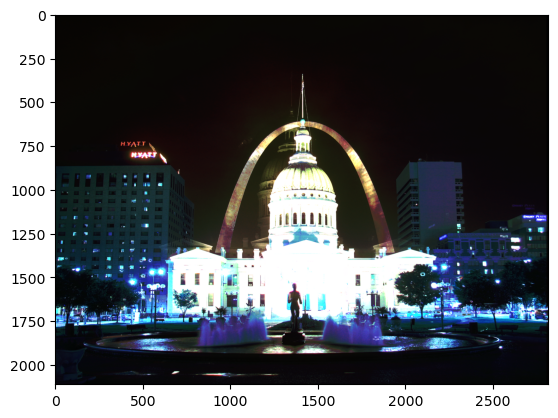

In [7]:
# Merge images into an HDR linear image using OpenCV's function
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)
# You may want to save the HDR image (radiance map).
cv2.imwrite("hdrDebevec.hdr", hdrDebevec)

import matplotlib.pyplot as plt
plt.imshow(hdrDebevec)

And you should implement your own code according to the equation below. The $w$ is the hat weighting function we used before.

$$\ln E_i = \frac{\Sigma_{j=1}^P w(Z_{ij})(g(Z_{ij})-\ln \Delta t_j)}{\Sigma_{j=1}^P w(Z_{ij})} $$

C:\Users\santa\AppData\Local\Temp\ipykernel_7924\2318025253.py:11: RuntimeWarning: invalid value encountered in divide
  tizu = tizu / sumDown
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D:\Anaconda\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


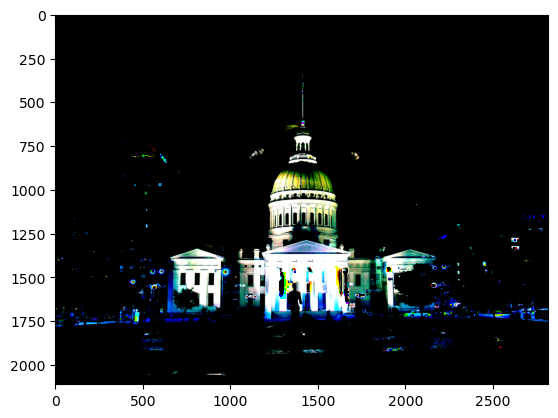

In [8]:
### TODO: recover the radiance map
def Map(images, times, g):
    tizu = np.zeros((images[0].shape[0], images[0].shape[1]))
    sumDown = np.zeros((images[0].shape[0], images[0].shape[1]))
    w = np.array([weight(z) for z in range(256)])
    for k in range(len(times)):
        Zij = images[k]
        Wij = w[Zij]
        tizu += Wij * (g[Zij][:, :, 0] - np.log(times[k]))
        sumDown += Wij
    tizu = tizu / sumDown
    return tizu


def RadianceMap(images, times, crf):
    images_b, images_g, images_r = split(images)
    radiancemap = np.zeros((images[0].shape[0], images[0].shape[1], 3), dtype=np.float32)
    radiancemap[:, :, 0] = Map(images_b, times, crf[0])
    radiancemap[:, :, 1] = Map(images_g, times, crf[1])
    radiancemap[:, :, 2] = Map(images_r, times, crf[2])
    return radiancemap


radiancemap = RadianceMap(images, times, getCRF(images, times, l=50))

# plot your radiance map
plt.imshow(radiancemap)

### Step 4: Tone mapping

Now we have merged our exposure images into one HDR image. Can you guess the minimum and maximum pixel values for this image? The minimum value is obviously 0 for a pitch black condition. What is the theoretical maximum value? Infinite! In practice, the maximum value is different for different situations. If the scene contains a very bright light source, we will see a very large maximum value.

Even though we have recovered the relative brightness information using multiple images, we now have the challenge of saving this information as a 24-bit image for display purposes.

> The process of converting a High Dynamic Range (HDR) image to an 8-bit per channel image while preserving as much detail as possible is called Tone mapping.

There are several tone mapping algorithms. OpenCV implements four of them. The thing to keep in mind is that there is no right way to do tone mapping. Usually, we want to see more detail in the tonemapped image than in any one of the exposure images. Sometimes the goal of tone mapping is to produce realistic images and often times the goal is to produce surreal images. The algorithms implemented in OpenCV tend to produce realistic and therefore less dramatic results.

Let’s look at the various options. Some of the common parameters of the different tone mapping algorithms are listed below.

* gamma : This parameter compresses the dynamic range by applying a gamma correction. When gamma is equal to 1, no correction is applied. A gamma of less than 1 darkens the image, while a gamma greater than 1 brightens the image.
* saturation : This parameter is used to increase or decrease the amount of saturation. When saturation is high, the colors are richer and more intense. Saturation value closer to zero, makes the colors fade away to grayscale.
* contrast : Controls the contrast ( i.e. log (maxPixelValue/minPixelValue) ) of the output image.

Let us explore one of the tone mapping algorithms available in OpenCV.

#### Reinhard Tonemap

```c++
createTonemapReinhard
(
float   gamma = 1.0f,
float   intensity = 0.0f,
float   light_adapt = 1.0f,
float   color_adapt = 0.0f
)
```

The parameter intensity should be in the [-8, 8] range. Greater intensity value produces brighter results. light_adapt controls the light adaptation and is in the [0, 1] range. A value of 1 indicates adaptation based only on pixel value and a value of 0 indicates global adaptation. An in-between value can be used for a weighted combination of the two. The parameter color_adapt controls chromatic adaptation and is in the [0, 1] range. The channels are treated independently if the value is set to 1 and the adaptation level is the same for every channel if the value is set to 0. An in-between value can be used for a weighted combination of the two.

For more details, check out this [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.106.8100&rep=rep1&type=pdf).

True

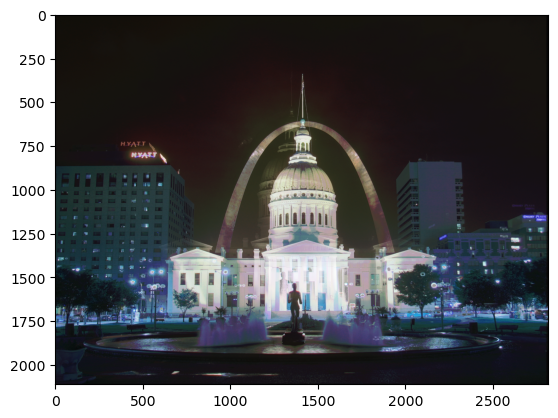

In [9]:
import matplotlib.pyplot as plt
# Tonemap using Reinhard's method to obtain 24-bit color image
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0,0,0)

### The following two lines is to tone map radiance map "hdrDebevec" from OpenCV's algorithm. Please use this function to tone map your radiance map and plot it.
ldrReinhard = tonemapReinhard.process(hdrDebevec)
plt.imshow(ldrReinhard)

### TODO: Call OpenCV's function to tonemap the radiance map you have recovered.
#ldrReinhard = tonemapReinhard.process(radiancemap)
#plt.imshow(ldrReinhard)

#You may want to save the tonemapped image to a file.
cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard * 255)


## Recent methods
There are HDRI challenges in [NTIRE](https://data.vision.ee.ethz.ch/cvl/ntire21/) (a workshop held in conjunction with CVPR). The HDRI challenge was held only in the year 2021 and 2022 by Huawei Noah ark Lab. The submitted methods in year 2021 (almost deep learning based) are summarized in this [paper](https://arxiv.org/abs/2106.01439) and the ones in year 2022 are [here](https://openaccess.thecvf.com/content/CVPR2022W/NTIRE/papers/Perez-Pellitero_NTIRE_2022_Challenge_on_High_Dynamic_Range_Imaging_Methods_and_CVPRW_2022_paper.pdf).

This awesome list [Awesome-High-Dynamic-Range-Imaging](https://github.com/rebeccaeexu/Awesome-High-Dynamic-Range-Imaging) collects most recent papers, datasets and other resources.

### Research paper reading
In this part, you are required to choose a recent research paper on HDRI from top conference (or journals), such as CVPR, ICCV etc. Write an essay about your chosen paper based on your interpretation (**must includes your critical thinking**) and post it on your blog. Copy the link to your essay in the following.

#### The link to your essay
[paper title - conference/journal name - year](http://the_url)

### Model playing
Most AI research papers are open-source. If your chosen paper is the case, please run the code and post the results below. It is recommended to use the images in your previous code above.

Note: If the solution of your chosen paper is data driven, there will probablely is a machine learning model. You don't need to train the model from scratch if the authors have provided their model parameter files. You just follow the instructions and manage to run the model.

True

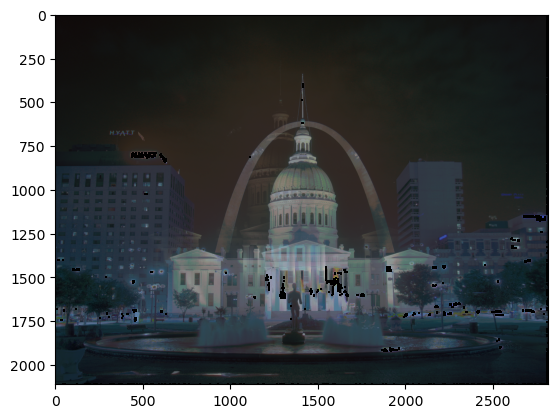

In [103]:
# TODO: Run the model and plot the results

## References

Book
- High dynamic range imaging: acquisition, display, and image-based lighting
    - Reinhard, Erik, et al. ,2010
    - The bible of the HDR imaging

HDR Image Reconstruction
- Debevec, Paul E., and Jitendra Malik. "Recovering high dynamic range radiance maps from photographs." Proceedings of the 24th annual conference on Computer graphics and interactive techniques. ACM Press/Addison-Wesley Publishing Co., 1997.
    - The basic but effective method for HDR image reconstruction, this paper motivates many works about HDR imaging
    - Matrix form solution(including least square term and smoothness term)
- Robertson, Mark, Sean Borman, and Robert L. Stevenson. "Dynamic range improvement through multiple exposures." Image Processing, 1999. ICIP 99. Proceedings. 1999 International Conference on. Vol. 3. IEEE, 1999.
    - Maximum likelihood solution, consider the additive noise and dequantization error as independent Gaussian random variable
    - Iterative method derived from the partial differential equation results
- Mitsunaga, Tomoo, and Shree K. Nayar. "Radiometric self calibration." Computer Vision and Pattern Recognition, 1999. IEEE Computer Society Conference on.. Vol. 1. IEEE, 1999.
    - Use polynomials to model the CRF
    - Iterative method with rough estimation of exposure time ratio
- Lin, Stephen, et al. "Radiometric calibration from a single image." Computer Vision and Pattern Recognition, 2004. CVPR 2004. Proceedings of the 2004 IEEE Computer Society Conference on. Vol. 2. IEEE, 2004.
    - Single image HDR scheme
    - Based on the edge color distribution

Image Alignment and Registration
- Ward, Greg. "Fast, robust image registration for compositing high dynamic range photographs from hand-held exposures." Journal of graphics tools 8.2 (2003): 17-30.
    - Median threshold bitmap (MTB) for global alignment
    - Very efficient (due to based on bitwise operation)
- Kang, Sing Bing, et al. "High dynamic range video." ACM Transactions on Graphics (TOG) 22.3 (2003): 319-325.
    - Both global and local registration
    - A variant of LK optical flow
    - A strategy to obtain HDR video

Alternative to HDR imaging
Exposure Fusion
Two series of paper
- Mertens, Tom, Jan Kautz, and Frank Van Reeth. "Exposure fusion." Computer Graphics and Applications, 2007. PG'07. 15th Pacific Conference on. IEEE, 2007.
- Mertens, Tom, Jan Kautz, and Frank Van Reeth. "Exposure fusion: A simple and practical alternative to high dynamic range photography." Computer Graphics Forum. Vol. 28. No. 1. Blackwell Publishing Ltd, 2009.
    - Scalar-weighted map is first generated based on the quality measurement (contrast, saturation, well-exposedness) of the exposure bracketed image, then the fusion is performed in the multiresolution manner (Each layer of the Laplacian pyramid of resulting image is computed by the pixel-based multiplication if Gaussian pyramids of the weighted map with Laplacian pyramids of the original image)